In [137]:
from typing import List, Dict, Any, Optional, Tuple, Iterable

In [138]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

載入價格

In [139]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 讀取NAS100資料
def load_nas100_data(file_path):
    """載入並預處理NAS100資料"""
    df = pd.read_csv(file_path)
    
    # 轉換時間格式
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # 使用BidClose作為主要價格
    df['Close'] = df['BidClose']
    df['High'] = df['BidHigh'] 
    df['Low'] = df['BidLow']
    df['Open'] = df['BidOpen']
    
    return df[['Open', 'High', 'Low', 'Close', 'Volume']]

# 資料重採樣
def resample_data(df, interval='1H'):
    """將15分鐘資料重採樣為指定間隔"""
    resampled = df.resample(interval).agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min', 
        'Close': 'last',
        'Volume': 'sum'
    }).dropna()
    
    return resampled

# 執行資料載入和重採樣
nas100_raw = load_nas100_data('equity_prices/XAUUSD.csv')

# # 僅保留 2015-11-01 之後
nas100_raw = nas100_raw.loc[nas100_raw.index >= '2018-11-01']
nas100_raw

# nas100_hourly = resample_data(nas100_raw, '1H')

# print(f"原始資料筆數: {len(nas100_raw)}")
# print(f"重採樣後筆數: {len(nas100_hourly)}")
# print(f"資料期間: {nas100_hourly.index[0]} 至 {nas100_hourly.index[-1]}")

,Open,High,Low,Close,Volume
Date,,,,,
2018-11-01 00:00:00,1215.90,1216.68,1215.82,1216.36,1933
2018-11-01 00:15:00,1216.36,1217.20,1216.14,1216.75,2623
2018-11-01 00:30:00,1216.75,1217.13,1215.83,1216.67,3958
2018-11-01 00:45:00,1216.67,1217.03,1216.26,1216.30,3258
2018-11-01 01:00:00,1216.30,1216.75,1215.79,1216.14,3136
...,...,...,...,...,...
2025-09-12 05:15:00,3656.01,3656.64,3652.82,3652.93,2428
2025-09-12 05:30:00,3652.93,3655.64,3652.09,3654.79,5567
2025-09-12 05:45:00,3654.79,3655.14,3651.88,3653.05,5352


回測代碼

In [140]:
# =====================================================
# 回測系統：訊號進場 + 停損停利（支援動態槓桿調整 + 百分比停利）
# =====================================================
class BacktestEngine:
    """回測引擎：處理進場、停損、停利邏輯（支援動態槓桿調整 + 百分比停利）"""
    
    def __init__(self, stop_loss_pct=0.5, take_profit_bars=32, take_profit_pct=0.5,
                 initial_capital=100000, base_leverage=1.0):
        """
        Parameters:
        -----------
        stop_loss_pct : float
            停損百分比（預設 0.0025 = 0.25%）
        take_profit_bars : int
            停利K線數（預設 32）
        take_profit_pct : float
            停利百分比（預設 0.0025 = 0.25%）
        initial_capital : float
            初始資金（預設 100000）
        base_leverage : float
            基礎槓桿倍數（預設 1.0，如果沒有提供動態槓桿時使用）
        """
        self.stop_loss_pct = stop_loss_pct
        self.take_profit_bars = take_profit_bars
        self.take_profit_pct = take_profit_pct
        self.initial_capital = initial_capital
        self.base_leverage = base_leverage
        self.trades = []
        self.price_df = None  # 保存價格數據供 Buy and Hold 計算使用
        
    def backtest(self, df: pd.DataFrame, signals: pd.Series, 
                 leverage_series: pd.Series = None) -> pd.DataFrame:
        """
        執行回測（強制做空 + 動態槓桿調整）
        
        Parameters:
        -----------
        df : pd.DataFrame
            價格資料（需包含 'Close', 'High', 'Low' 欄位）
        signals : pd.Series
            進場信號（True 表示進場點，需與 df 的 index 對齊）
        leverage_series : pd.Series, optional
            每筆交易的槓桿倍數（需與 df 的 index 對齊）
            如果為None，則所有交易使用base_leverage
            
        Returns:
        --------
        results : pd.DataFrame
            回測結果，包含每筆交易的詳細資訊
        """
        df = df.copy()
        # df['side'] = -1
        signals = signals.copy()
        
        # 保存價格數據供後續使用（用於 buy and hold 計算）
        self.price_df = df.copy()
        
        # 確保 signals 與 df 的 index 對齊
        if not signals.index.equals(df.index):
            signals = signals.reindex(df.index, fill_value=False)
        
        # 處理槓桿倍數
        if leverage_series is None:
            leverage_series = pd.Series(self.base_leverage, index=df.index)
        else:
            leverage_series = leverage_series.copy()
            if not leverage_series.index.equals(df.index):
                leverage_series = leverage_series.reindex(df.index, fill_value=self.base_leverage)
        
        # 初始化狀態
        position = None  # None: 無持倉, dict: {entry_time, entry_price, side, units, leverage, capital_used}
        trades = []
        current_equity = self.initial_capital  # 當前總equity
        
        for i, (timestamp, row) in enumerate(df.iterrows()):
            current_close = row['Close']
            current_high = row['High']
            current_low = row['Low']
            has_signal = signals.loc[timestamp]
            leverage = leverage_series.loc[timestamp]
            
            # ============================================
            # 邏輯1: 檢查進場條件（確保同時只會進場一次）
            # ============================================
            if has_signal and position is None:
                # 強制做空
                entry_side = -1
                
                # 計算可進場的單位數
                # 可用資金 = 當前總equity * 槓桿倍數
                available_capital = current_equity * leverage
                
                # 計算可買入的單位數（假設1單位 = 1價格）
                # 實際應用中可能需要根據合約規格調整
                units = (available_capital / current_close) * 1
                
                # 實際使用的資金（不考慮槓桿時的資金）
                capital_used = current_equity
                
                # 以收盤價進場
                position = {
                    'entry_time': timestamp,
                    'entry_price': current_close,
                    'entry_idx': i,
                    'side': entry_side,
                    'units': units,  # 進場單位數
                    'leverage': leverage,  # 使用的槓桿倍數
                    'capital_used': capital_used  # 使用的資金
                }
                continue
            
            # ============================================
            # 邏輯2: 如果有持倉，檢查停損停利
            # ============================================
            if position is not None:
                entry_price = position['entry_price']
                entry_idx = position['entry_idx']
                side = position['side']
                units = position['units']
                leverage_used = position['leverage']
                capital_used = position['capital_used']
                
                # 計算停損價格
                stop_loss_price = entry_price * (1 - self.stop_loss_pct * side)
                
                # 計算停利價格
                take_profit_price = entry_price * (1 + self.take_profit_pct * side)
                
                # 計算持倉K線數
                bars_held = i - entry_idx
                
                # 檢查停損
                hit_stop_loss = False
                exit_price = None
                exit_reason = None
                
                # 因為強制做空，其實只需要保留做空的判斷，但為了保險保留 side 判斷
                if side == 1:  # 做多
                    if current_low <= stop_loss_price:
                        hit_stop_loss = True
                        exit_price = stop_loss_price
                        exit_reason = 'Stop Loss'
                elif side == -1: # 做空
                    if current_high >= stop_loss_price:
                        hit_stop_loss = True
                        exit_price = stop_loss_price
                        exit_reason = 'Stop Loss'
                
                # 檢查百分比停利
                hit_take_profit_pct = False
                if not hit_stop_loss:
                    if side == 1:  # 做多
                        if current_high >= take_profit_price:
                            hit_take_profit_pct = True
                            exit_price = take_profit_price
                            exit_reason = 'Take Profit (0.25%)'
                    elif side == -1: # 做空
                        if current_low <= take_profit_price:
                            hit_take_profit_pct = True
                            exit_price = take_profit_price
                            exit_reason = 'Take Profit (0.25%)'
                
                # 檢查時間停利（32根K後以收盤價平倉）
                hit_take_profit_bars = False
                if bars_held >= self.take_profit_bars:
                    hit_take_profit_bars = True
                    # 如果還沒觸發百分比停利，才使用時間停利
                    if not hit_take_profit_pct and not hit_stop_loss:
                        exit_price = current_close
                        exit_reason = 'Take Profit (32 bars)'
                
                # 如果觸發停損或停利，執行平倉
                if hit_stop_loss or hit_take_profit_pct or hit_take_profit_bars:
                    # 計算實際盈虧金額
                    # 修正公式：(出場價 - 進場價) * 單位數 * 方向
                    # 做空時 (side=-1)：(Exit - Entry) * -1 = Entry - Exit (跌價賺錢)
                    pnl = (exit_price - entry_price) * units * side - entry_price*0.0001
                    
                    # 計算報酬率（相對於使用的資金）
                    return_pct = (pnl / capital_used) * 100 if capital_used > 0 else 0
                    
                    # 更新當前總equity
                    current_equity = current_equity + pnl
                    
                    # 記錄交易
                    trade = {
                        'entry_time': position['entry_time'],
                        'exit_time': timestamp,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'side': side,
                        'units': units,
                        'leverage': leverage_used,
                        'capital_used': capital_used,
                        'pnl': pnl,  # 盈虧金額
                        'return_pct': return_pct,  # 報酬率
                        'bars_held': bars_held,
                        'exit_reason': exit_reason,
                        'stop_loss_price': stop_loss_price,
                        'take_profit_price': take_profit_price,
                        'equity_after': current_equity  # 平倉後總equity
                    }
                    trades.append(trade)
                    
                    # 重置持倉
                    position = None
        
        # 處理最後一筆未平倉的交易（如果有的話）
        if position is not None:
            last_timestamp = df.index[-1]
            last_close = df['Close'].iloc[-1]
            entry_price = position['entry_price']
            side = position['side']
            units = position['units']
            leverage_used = position['leverage']
            capital_used = position['capital_used']
            bars_held = len(df) - 1 - position['entry_idx']
            
            # 這裡的公式原本就是對的 (last_close - entry_price) * units * side
            pnl = (last_close - entry_price) * units * side
            return_pct = (pnl / capital_used) * 100 if capital_used > 0 else 0
            current_equity = current_equity + pnl
            
            trade = {
                'entry_time': position['entry_time'],
                'exit_time': last_timestamp,
                'entry_price': entry_price,
                'exit_price': last_close,
                'side': side,
                'units': units,
                'leverage': leverage_used,
                'capital_used': capital_used,
                'pnl': pnl,
                'return_pct': return_pct,
                'bars_held': bars_held,
                'exit_reason': 'End of Data',
                'stop_loss_price': entry_price * (1 - self.stop_loss_pct * side),
                'take_profit_price': entry_price * (1 + self.take_profit_pct * side),
                'equity_after': current_equity
            }
            trades.append(trade)
        
        # 轉換為 DataFrame
        if trades:
            results = pd.DataFrame(trades)
            self.trades = results
            self.final_equity = current_equity
            return results
        else:
            print("⚠️ 沒有產生任何交易")
            self.final_equity = current_equity
            return pd.DataFrame()
        
    def get_performance_metrics(self) -> dict:
        """計算績效指標"""
        if len(self.trades) == 0:
            return {}
        
        df = self.trades
        
        total_trades = len(df)
        winning_trades = len(df[df['pnl'] > 0])
        losing_trades = len(df[df['pnl'] < 0])
        
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        
        total_pnl = df['pnl'].sum()
        total_return_pct = ((self.final_equity - self.initial_capital) / self.initial_capital) * 100
        avg_return = df['return_pct'].mean()
        
        avg_win = df[df['pnl'] > 0]['return_pct'].mean() if winning_trades > 0 else 0
        avg_loss = df[df['pnl'] < 0]['return_pct'].mean() if losing_trades > 0 else 0
        
        avg_win_amount = df[df['pnl'] > 0]['pnl'].mean() if winning_trades > 0 else 0
        avg_loss_amount = df[df['pnl'] < 0]['pnl'].mean() if losing_trades > 0 else 0
        
        profit_factor = abs(avg_win_amount * winning_trades / (avg_loss_amount * losing_trades)) if losing_trades > 0 and avg_loss_amount != 0 else np.inf
        
        # 統計停損停利次數
        stop_loss_count = len(df[df['exit_reason'] == 'Stop Loss'])
        take_profit_pct_count = len(df[df['exit_reason'] == 'Take Profit (0.25%)'])
        take_profit_bars_count = len(df[df['exit_reason'] == 'Take Profit (32 bars)'])
        
        # 統計32根K後的賺錢和虧錢出場
        take_profit_bars_trades = df[df['exit_reason'] == 'Take Profit (32 bars)']
        take_profit_bars_win = len(take_profit_bars_trades[take_profit_bars_trades['pnl'] > 0])
        take_profit_bars_loss = len(take_profit_bars_trades[take_profit_bars_trades['pnl'] <= 0])
        
        # 統計百分比停利的賺錢和虧錢出場
        take_profit_pct_trades = df[df['exit_reason'] == 'Take Profit (0.25%)']
        take_profit_pct_win = len(take_profit_pct_trades[take_profit_pct_trades['pnl'] > 0])
        take_profit_pct_loss = len(take_profit_pct_trades[take_profit_pct_trades['pnl'] <= 0])
        
        # 統計不同槓桿的交易
        if 'leverage' in df.columns:
            leverage_0_5 = len(df[df['leverage'] == 0.5])
            leverage_1_0 = len(df[df['leverage'] == 1.0])
            leverage_2_0 = len(df[df['leverage'] == 2.0])
        else:
            leverage_0_5 = leverage_1_0 = leverage_2_0 = 0
        
        metrics = {
            'Initial Capital': self.initial_capital,
            'Final Equity': self.final_equity,
            'Total PnL': total_pnl,
            'Total Return (%)': total_return_pct,
            'Total Trades': total_trades,
            'Winning Trades': winning_trades,
            'Losing Trades': losing_trades,
            'Win Rate (%)': win_rate * 100,
            'Average Return (%)': avg_return,
            'Average Win (%)': avg_win,
            'Average Loss (%)': avg_loss,
            'Average Win Amount': avg_win_amount,
            'Average Loss Amount': avg_loss_amount,
            'Profit Factor': profit_factor,
            'Stop Loss Count': stop_loss_count,
            'Take Profit Pct Count': take_profit_pct_count,
            'Take Profit Pct Win Count': take_profit_pct_win,
            'Take Profit Pct Loss Count': take_profit_pct_loss,
            'Take Profit Bars Count': take_profit_bars_count,
            'Take Profit Bars Win Count': take_profit_bars_win,
            'Take Profit Bars Loss Count': take_profit_bars_loss,
            'Leverage 0.5x Count': leverage_0_5,
            'Leverage 1.0x Count': leverage_1_0,
            'Leverage 2.0x Count': leverage_2_0
        }
        
        return metrics
    
    def print_summary(self):
        """印出回測摘要"""
        if len(self.trades) == 0:
            print("⚠️ 沒有交易記錄")
            return
        
        metrics = self.get_performance_metrics()
        
        print("=" * 60)
        print("📊 回測結果摘要（含動態槓桿調整 + 百分比停利）")
        print("=" * 60)
        print(f"初始資金: ${metrics['Initial Capital']:,.2f}")
        print(f"最終總equity: ${metrics['Final Equity']:,.2f}")
        print(f"總盈虧: ${metrics['Total PnL']:,.2f}")
        print(f"總報酬率: {metrics['Total Return (%)']:.2f}%")
        print(f"總交易次數: {metrics['Total Trades']:,}")
        print(f"獲利交易: {metrics['Winning Trades']:,}")
        print(f"虧損交易: {metrics['Losing Trades']:,}")
        print(f"勝率: {metrics['Win Rate (%)']:.2f}%")
        print(f"平均報酬率: {metrics['Average Return (%)']:.2f}%")
        print(f"平均獲利: {metrics['Average Win (%)']:.2f}% (${metrics['Average Win Amount']:,.2f})")
        print(f"平均虧損: {metrics['Average Loss (%)']:.2f}% (${metrics['Average Loss Amount']:,.2f})")
        print(f"獲利因子: {metrics['Profit Factor']:.2f}")
        print(f"停損次數: {metrics['Stop Loss Count']:,}")
        print(f"百分比停利次數 (0.25%): {metrics['Take Profit Pct Count']:,}")
        print(f"  0.25%停利賺錢出場: {metrics['Take Profit Pct Win Count']:,}")
        print(f"  0.25%停利虧錢出場: {metrics['Take Profit Pct Loss Count']:,}")
        print(f"時間停利次數 (32根K): {metrics['Take Profit Bars Count']:,}")
        print(f"  32根K後賺錢出場: {metrics['Take Profit Bars Win Count']:,}")
        print(f"  32根K後虧錢出場: {metrics['Take Profit Bars Loss Count']:,}")
        print(f"槓桿分布:")
        print(f"  0.5x槓桿: {metrics['Leverage 0.5x Count']:,}")
        print(f"  1.0x槓桿: {metrics['Leverage 1.0x Count']:,}")
        print(f"  2.0x槓桿: {metrics['Leverage 2.0x Count']:,}")
        print("=" * 60)
    
    def plot_equity_curve(self):
        """繪製權益曲線（含 Buy and Hold 比較 + 最大回撤標記）"""
        import matplotlib.pyplot as plt
        from datetime import datetime

        if len(self.trades) == 0:
            print("⚠️ 沒有交易記錄")
            return

        if not hasattr(self, 'price_df') or self.price_df is None:
            print("⚠️ 缺少價格數據，無法計算 Buy and Hold 績效")
            return

        df = self.trades.copy()
        price_df = self.price_df.copy()

        df['cumulative_equity'] = self.initial_capital + df['pnl'].cumsum()
        df['cumulative_return_pct'] = ((df['cumulative_equity'] - self.initial_capital) / self.initial_capital) * 100

        # 最大回撤計算
        df['running_max'] = df['cumulative_equity'].cummax()
        df['drawdown_pct'] = (df['cumulative_equity'] / df['running_max'] - 1.0) * 100
        max_dd_pct = df['drawdown_pct'].min()
        max_dd_idx = df['drawdown_pct'].idxmin()
        max_dd_end_time = df.loc[max_dd_idx, 'exit_time']
        max_dd_start_idx = df.loc[:max_dd_idx, 'cumulative_equity'].idxmax()
        max_dd_start_time = df.loc[max_dd_start_idx, 'exit_time']

        first_entry_time = df['entry_time'].iloc[0] if len(df) > 0 else price_df.index[0]
        last_time = price_df.index[-1]
        start_price = price_df.loc[price_df.index >= first_entry_time, 'Close'].iloc[0]
        end_price = price_df['Close'].iloc[-1]
        bh_return_pct = ((end_price - start_price) / start_price) * 100
        bh_final_equity = self.initial_capital * (1 + bh_return_pct / 100)

        # 計算年化收益率
        # 策略時間跨度
        strategy_start = pd.to_datetime(first_entry_time)
        strategy_end = pd.to_datetime(df['exit_time'].iloc[-1])
        strategy_years = (strategy_end - strategy_start).total_seconds() / (365.25 * 24 * 3600)
        
        # Buy and Hold 時間跨度
        bh_start = pd.to_datetime(first_entry_time)
        bh_end = pd.to_datetime(last_time)
        bh_years = (bh_end - bh_start).total_seconds() / (365.25 * 24 * 3600)
        
        # 策略年化收益率
        strategy_total_return = df['cumulative_return_pct'].iloc[-1] / 100
        if strategy_years > 0:
            strategy_annualized_return = ((1 + strategy_total_return) ** (1 / strategy_years) - 1) * 100
        else:
            strategy_annualized_return = 0
        
        # Buy and Hold 年化收益率
        bh_total_return = bh_return_pct / 100
        if bh_years > 0:
            bh_annualized_return = ((1 + bh_total_return) ** (1 / bh_years) - 1) * 100
        else:
            bh_annualized_return = 0

        strategy_period = price_df.loc[price_df.index >= first_entry_time].copy()
        strategy_period['bh_equity'] = self.initial_capital * (1 + (strategy_period['Close'] - start_price) / start_price)
        strategy_period['bh_return_pct'] = ((strategy_period['bh_equity'] - self.initial_capital) / self.initial_capital) * 100

        stop_loss_trades = df[df['exit_reason'] == 'Stop Loss']
        take_profit_pct_trades = df[df['exit_reason'] == 'Take Profit (0.25%)']
        take_profit_bars_win = df[(df['exit_reason'] == 'Take Profit (32 bars)') & (df['pnl'] > 0)]
        take_profit_bars_loss = df[(df['exit_reason'] == 'Take Profit (32 bars)') & (df['pnl'] <= 0)]
        end_of_data = df[df['exit_reason'] == 'End of Data']

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 14))

        # Equity 曲線
        ax1.plot(df['exit_time'], df['cumulative_equity'],
                 linewidth=2, color='blue', alpha=0.7, label='Strategy Equity', marker='o', markersize=3)
        ax1.plot(strategy_period.index, strategy_period['bh_equity'],
                 linewidth=2, color='orange', alpha=0.7, label='Buy and Hold Equity', linestyle='--')
        ax1.axhline(y=self.initial_capital, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
        ax1.axvspan(max_dd_start_time, max_dd_end_time, color='red', alpha=0.1, label='Max Drawdown Window')
        ax1.annotate(f'MDD: {abs(max_dd_pct):.2f}%',
                     xy=(max_dd_end_time, df.loc[max_dd_idx, 'cumulative_equity']),
                     xytext=(0, -40), textcoords='offset points',
                     arrowprops=dict(arrowstyle='->', color='red'),
                     color='red', fontsize=10, fontweight='bold')
        ax1.set_title('Equity Curve Comparison', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Time', fontsize=12)
        ax1.set_ylabel('Equity ($)', fontsize=12)
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

        # 累積報酬率
        ax2.plot(df['exit_time'], df['cumulative_return_pct'],
                 linewidth=2, color='green', alpha=0.7, label='Strategy Return (%)', marker='o', markersize=3)
        ax2.plot(strategy_period.index, strategy_period['bh_return_pct'],
                 linewidth=2, color='orange', alpha=0.7, label='Buy and Hold Return (%)', linestyle='--')

        if len(stop_loss_trades) > 0:
            ax2.scatter(stop_loss_trades['exit_time'], stop_loss_trades['cumulative_return_pct'],
                        color='red', s=30, alpha=0.6,
                        label=f'Stop Loss ({len(stop_loss_trades)})', marker='x')
        if len(take_profit_pct_trades) > 0:
            ax2.scatter(take_profit_pct_trades['exit_time'], take_profit_pct_trades['cumulative_return_pct'],
                        color='lime', s=50, alpha=0.7,
                        label=f'0.25% Take Profit ({len(take_profit_pct_trades)})', marker='*')
        if len(take_profit_bars_win) > 0:
            ax2.scatter(take_profit_bars_win['exit_time'], take_profit_bars_win['cumulative_return_pct'],
                        color='green', s=50, alpha=0.7,
                        label=f'32 Bars Profit ({len(take_profit_bars_win)})', marker='^')
        if len(take_profit_bars_loss) > 0:
            ax2.scatter(take_profit_bars_loss['exit_time'], take_profit_bars_loss['cumulative_return_pct'],
                        color='orange', s=50, alpha=0.7,
                        label=f'32 Bars Loss ({len(take_profit_bars_loss)})', marker='v')
        if len(end_of_data) > 0:
            ax2.scatter(end_of_data['exit_time'], end_of_data['cumulative_return_pct'],
                        color='gray', s=30, alpha=0.5,
                        label=f'End of Data ({len(end_of_data)})', marker='s')

        ax2.set_title('Cumulative Return (%) Comparison', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Time', fontsize=12)
        ax2.set_ylabel('Cumulative Return (%)', fontsize=12)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

        # 文字摘要
        ax3.axis('off')
        strategy_final_return = df['cumulative_return_pct'].iloc[-1]
        strategy_final_equity = df['cumulative_equity'].iloc[-1]
        excess_return = strategy_final_return - bh_return_pct
        excess_annualized_return = strategy_annualized_return - bh_annualized_return
        comparison_text = f"""
            Performance Comparison Summary
            {'=' * 50}
            Strategy Performance:
            Final Equity: ${strategy_final_equity:,.2f}
            Total Return: {strategy_final_return:.2f}%
            Annualized Return: {strategy_annualized_return:.2f}%
            Period: {strategy_years:.2f} years
            Total Trades: {len(df):,}
            Win Rate: {len(df[df['pnl'] > 0]) / len(df) * 100:.2f}%

            Buy and Hold Performance:
            Final Equity: ${bh_final_equity:,.2f}
            Total Return: {bh_return_pct:.2f}%
            Annualized Return: {bh_annualized_return:.2f}%
            Period: {bh_years:.2f} years
            Entry Price: ${start_price:.2f}
            Exit Price: ${end_price:.2f}

            Comparison:
            Excess Return: {excess_return:.2f}%
            Excess Annualized Return: {excess_annualized_return:.2f}%
            {'Strategy Outperforms' if excess_return > 0 else 'Buy and Hold Outperforms'}

            Risk Metrics:
            Max Drawdown: {abs(max_dd_pct):.2f}%
            MDD Window: {max_dd_start_time} → {max_dd_end_time}
        """
        ax3.text(0.1, 0.5, comparison_text, fontsize=11,
                 family='monospace', verticalalignment='center',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        # Drawdown 圖
        ax4.fill_between(df['exit_time'], 0, df['drawdown_pct'],
                         color='crimson', alpha=0.3, step='mid')
        ax4.set_title('Drawdown (%)', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Time', fontsize=12)
        ax4.set_ylabel('Drawdown (%)', fontsize=12)
        ax4.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        ax4.grid(True, alpha=0.3)
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

        plt.tight_layout()
        plt.show()
        
    def get_monthly_statistics(self) -> pd.DataFrame:
        """計算每月統計（勝率、盈虧等）"""
        if len(self.trades) == 0:
            print("⚠️ 沒有交易記錄")
            return pd.DataFrame()
        
        df = self.trades.copy()
        
        # 使用 exit_time 作為月份分組依據（因為盈虧在出場時實現）
        df['exit_time'] = pd.to_datetime(df['exit_time'])
        df['year_month'] = df['exit_time'].dt.to_period('M')
        
        # 按月分組統計
        monthly_stats = df.groupby('year_month').agg({
            'pnl': ['sum', 'count'],
            'return_pct': 'mean'
        }).reset_index()
        
        # 重新命名欄位
        monthly_stats.columns = ['year_month', 'total_pnl', 'trade_count', 'avg_return_pct']
        
        # 計算每月勝率
        monthly_win_rate = df.groupby('year_month').apply(
            lambda x: (x['pnl'] > 0).sum() / len(x) * 100 if len(x) > 0 else 0
        ).reset_index(name='win_rate_pct')
        
        # 合併統計
        monthly_stats = monthly_stats.merge(monthly_win_rate, on='year_month', how='left')
        
        # 計算每月賺錢/虧錢
        monthly_stats['is_profitable'] = monthly_stats['total_pnl'] > 0
        
        # 轉換 year_month 為字串格式（用於顯示）
        monthly_stats['month_str'] = monthly_stats['year_month'].astype(str)
        
        return monthly_stats
    
    def print_monthly_summary(self):
        """印出每月統計摘要"""
        if len(self.trades) == 0:
            print("⚠️ 沒有交易記錄")
            return
        
        monthly_stats = self.get_monthly_statistics()
        
        if len(monthly_stats) == 0:
            print("⚠️ 無法計算每月統計")
            return
        
        # 計算總體統計
        total_months = len(monthly_stats)
        profitable_months = monthly_stats['is_profitable'].sum()
        losing_months = total_months - profitable_months
        
        print("=" * 60)
        print("📊 每月統計摘要")
        print("=" * 60)
        print(f"總月份數: {total_months}")
        print(f"賺錢月份: {profitable_months} ({profitable_months/total_months*100:.2f}%)")
        print(f"虧錢月份: {losing_months} ({losing_months/total_months*100:.2f}%)")
        print("=" * 60)
        print("\n每月詳細統計:")
        print("-" * 60)
        
        for _, row in monthly_stats.iterrows():
            month_str = row['month_str']
            total_pnl = row['total_pnl']
            trade_count = int(row['trade_count'])
            win_rate = row['win_rate_pct']
            status = "Profit" if row['is_profitable'] else "Loss"
            
            print(f"{month_str}: {status:6s} | PnL: ${total_pnl:>10,.2f} | "
                  f"Trades: {trade_count:>4d} | Win Rate: {win_rate:>6.2f}%")
        
        print("=" * 60)
    
    def plot_monthly_pnl(self):
        """繪製每月盈虧柱狀圖"""
        import matplotlib.pyplot as plt
        
        if len(self.trades) == 0:
            print("⚠️ 沒有交易記錄")
            return
        
        monthly_stats = self.get_monthly_statistics()
        
        if len(monthly_stats) == 0:
            print("⚠️ 無法計算每月統計")
            return
        
        # 準備數據
        months = monthly_stats['month_str'].values
        pnl_values = monthly_stats['total_pnl'].values
        
        # 區分賺錢和虧錢的月份
        profitable_mask = monthly_stats['is_profitable'].values
        profitable_pnl = np.where(profitable_mask, pnl_values, 0)
        losing_pnl = np.where(~profitable_mask, pnl_values, 0)
        
        # 繪製圖表
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        # ============================================
        # 上圖：每月盈虧柱狀圖（分顏色）
        # ============================================
        x_pos = np.arange(len(months))
        width = 0.6
        
        # 賺錢的月份用綠色，虧錢的月份用紅色
        bars1 = ax1.bar(x_pos, profitable_pnl, width, 
                       color='green', alpha=0.7, label='Profitable Months')
        bars2 = ax1.bar(x_pos, losing_pnl, width,
                       color='red', alpha=0.7, label='Losing Months')
        
        ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        ax1.set_xlabel('Month', fontsize=12)
        ax1.set_ylabel('PnL ($)', fontsize=12)
        ax1.set_title('Monthly Profit and Loss', fontsize=14, fontweight='bold')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(months, rotation=45, ha='right')
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3, axis='y')
        
        # 在柱狀圖上標註數值
        for i, (prof, loss) in enumerate(zip(profitable_pnl, losing_pnl)):
            if prof != 0:
                ax1.text(i, prof, f'${prof:,.0f}', 
                        ha='center', va='bottom' if prof > 0 else 'top', 
                        fontsize=8, fontweight='bold')
            if loss != 0:
                ax1.text(i, loss, f'${loss:,.0f}', 
                        ha='center', va='top' if loss < 0 else 'bottom', 
                        fontsize=8, fontweight='bold')
        
        # ============================================
        # 下圖：每月勝率
        # ============================================
        win_rates = monthly_stats['win_rate_pct'].values
        colors = ['green' if pnl > 0 else 'red' for pnl in pnl_values]
        
        bars3 = ax2.bar(x_pos, win_rates, width, color=colors, alpha=0.7)
        ax2.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% Win Rate')
        ax2.set_xlabel('Month', fontsize=12)
        ax2.set_ylabel('Win Rate (%)', fontsize=12)
        ax2.set_title('Monthly Win Rate', fontsize=14, fontweight='bold')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(months, rotation=45, ha='right')
        ax2.set_ylim([0, 105])
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3, axis='y')
        
        # 在柱狀圖上標註數值
        for i, (wr, pnl) in enumerate(zip(win_rates, pnl_values)):
            ax2.text(i, wr, f'{wr:.1f}%', 
                    ha='center', va='bottom', 
                    fontsize=8, fontweight='bold')
        
        # 添加總體統計文字
        total_months = len(monthly_stats)
        profitable_months = monthly_stats['is_profitable'].sum()
        losing_months = total_months - profitable_months
        
        stats_text = f"Total Months: {total_months} | "
        stats_text += f"Profitable: {profitable_months} ({profitable_months/total_months*100:.1f}%) | "
        stats_text += f"Losing: {losing_months} ({losing_months/total_months*100:.1f}%)"
        
        fig.suptitle(stats_text, fontsize=11, y=0.995)
        
        plt.tight_layout()
        plt.show()

策略代碼

In [141]:

# =====================================================
# 3️⃣ S1 策略 Class (做空)
# =====================================================
class S1Strategy:
    """S1 做空策略"""
    
    def __init__(self, entry_param: float = 0.5, entry_param2: float = 0.4, rolling_window: int = 460):
        self.entry_param = entry_param
        self.entry_param2 = entry_param2
        self.rolling_window = rolling_window
        self.signals = None
        
    def calculate_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        
        # 計算 HL115
        df['HL115'] = (
            df['High'].shift(1).rolling(self.rolling_window, min_periods=self.rolling_window).max() - 
            df['Low'].shift(1).rolling(self.rolling_window, min_periods=self.rolling_window).min()
        )
        
        # 計算 lowpoint
        prev_low_min = df['Low'].shift(1).rolling(self.rolling_window).min()
        prev_high_max = df['High'].shift(1).rolling(self.rolling_window).max()
        
        # 避免除以零
        denom = prev_high_max - prev_low_min
        denom = denom.replace(0, np.nan)
        
        df['lowpoint'] = (df['Low'] - prev_low_min) / denom
        
        # 計算 avg_lowpoint
        df['avg_lowpoint'] = df['lowpoint'].shift(1).rolling(self.rolling_window).mean()
        
        # 計算 突破signal價
        df['突破signal價'] = prev_low_min + (self.entry_param * df['HL115'])
        
        # 生成信號
        # 條件: Low < 突破價 & Open > 突破價 & avg_lowpoint < entry_param2
        condition = (
            (df['Low'] < df['突破signal價']) & 
            (df['Open'] > df['突破signal價'])  
            # (df['avg_lowpoint'] < self.entry_param2)
        )
        
        df['signal'] = condition
        df.loc[df.index[:115], 'signal'] = False
        
        # 轉換為 side (-1 做空)
        df['side'] = np.nan
        df.loc[df['signal'] == True, 'side'] = -1.0
        df['side'] = df['side'].ffill()
        
        self.signals = df
        
        # 統計
        total_bars = len(df)
        signal_count = df['signal'].sum()
        signal_rate = signal_count / total_bars if total_bars > 0 else 0
        
        print("=" * 60)
        print("📊 S1 策略統計 (Short)")
        print("=" * 60)
        print(f"總 K 線數: {total_bars:,}")
        print(f"信號數量: {signal_count:,}")
        print(f"信號比例: {signal_rate:.4%}")
        print(f"策略參數: entry_param={self.entry_param}, entry_param2={self.entry_param2}, rolling_window={self.rolling_window}")
        print("=" * 60)
        
        return df
    
    def get_signal_events(self) -> pd.DatetimeIndex:
        if self.signals is None:
            print("⚠️ 請先執行 calculate_indicators()")
            return None
        return self.signals[self.signals['signal'] == True].index
    
    def plot_strategy(self, start_idx: Optional[int] = None, end_idx: Optional[int] = None):
        import matplotlib.pyplot as plt
        if self.signals is None:
            print("⚠️ 請先執行 calculate_indicators()")
            return
        
        df = self.signals.iloc[start_idx:end_idx] if start_idx or end_idx else self.signals
        signal_events = df[df['signal'] == True].index
        
        fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
        
        # 1. 價格與突破信號
        axes[0].plot(df.index, df['Close'], label='Close Price', alpha=0.7, linewidth=1)
        axes[0].plot(df.index, df['突破signal價'], label='Breakout Signal', linestyle='--', alpha=0.7, color='orange')
        axes[0].scatter(signal_events, df.loc[signal_events, 'Close'], color='green', s=50, label='Short Signal', zorder=5, marker='v')
        axes[0].set_title(f'S1 Strategy (Short)', fontsize=12)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # 2. lowpoint & avg_lowpoint
        axes[1].plot(df.index, df['lowpoint'], label='lowpoint', alpha=0.5, linewidth=0.5)
        axes[1].plot(df.index, df['avg_lowpoint'], label='avg_lowpoint', color='red', linewidth=1)
        axes[1].axhline(y=self.entry_param2, color='gray', linestyle='--', label='Threshold')
        axes[1].set_title('Lowpoint Indicator', fontsize=12)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # 3. HL115
        axes[2].plot(df.index, df['HL115'], label='HL115', color='orange', linewidth=1)
        axes[2].set_title('HL115', fontsize=12)
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


## 依照策略訊號進出

📊 S1 策略統計 (Short)
總 K 線數: 162,577
信號數量: 3,036
信號比例: 1.8674%
策略參數: entry_param=0.5, entry_param2=0.4, rolling_window=500

前10筆交易:
             entry_time           exit_time  entry_price  exit_price  side  \
854 2025-07-16 13:30:00 2025-07-16 15:00:00      3326.99  3343.62495    -1   
855 2025-07-17 02:00:00 2025-07-17 10:00:00      3340.57  3327.03000    -1   
856 2025-07-24 06:15:00 2025-07-24 14:15:00      3371.66  3373.04000    -1   
857 2025-07-24 14:45:00 2025-07-24 23:45:00      3373.61  3369.38000    -1   
858 2025-08-11 01:00:00 2025-08-11 09:00:00      3372.84  3356.01000    -1   
859 2025-08-14 00:45:00 2025-08-14 08:45:00      3369.52  3346.15000    -1   
860 2025-08-20 13:45:00 2025-08-20 22:45:00      3344.84  3349.58000    -1   
861 2025-08-21 00:15:00 2025-08-21 08:15:00      3343.66  3339.81000    -1   
862 2025-08-21 12:15:00 2025-08-21 20:15:00      3337.03  3338.56000    -1   
863 2025-08-22 01:45:00 2025-08-22 09:45:00      3333.99  3330.06000    -1   

         uni

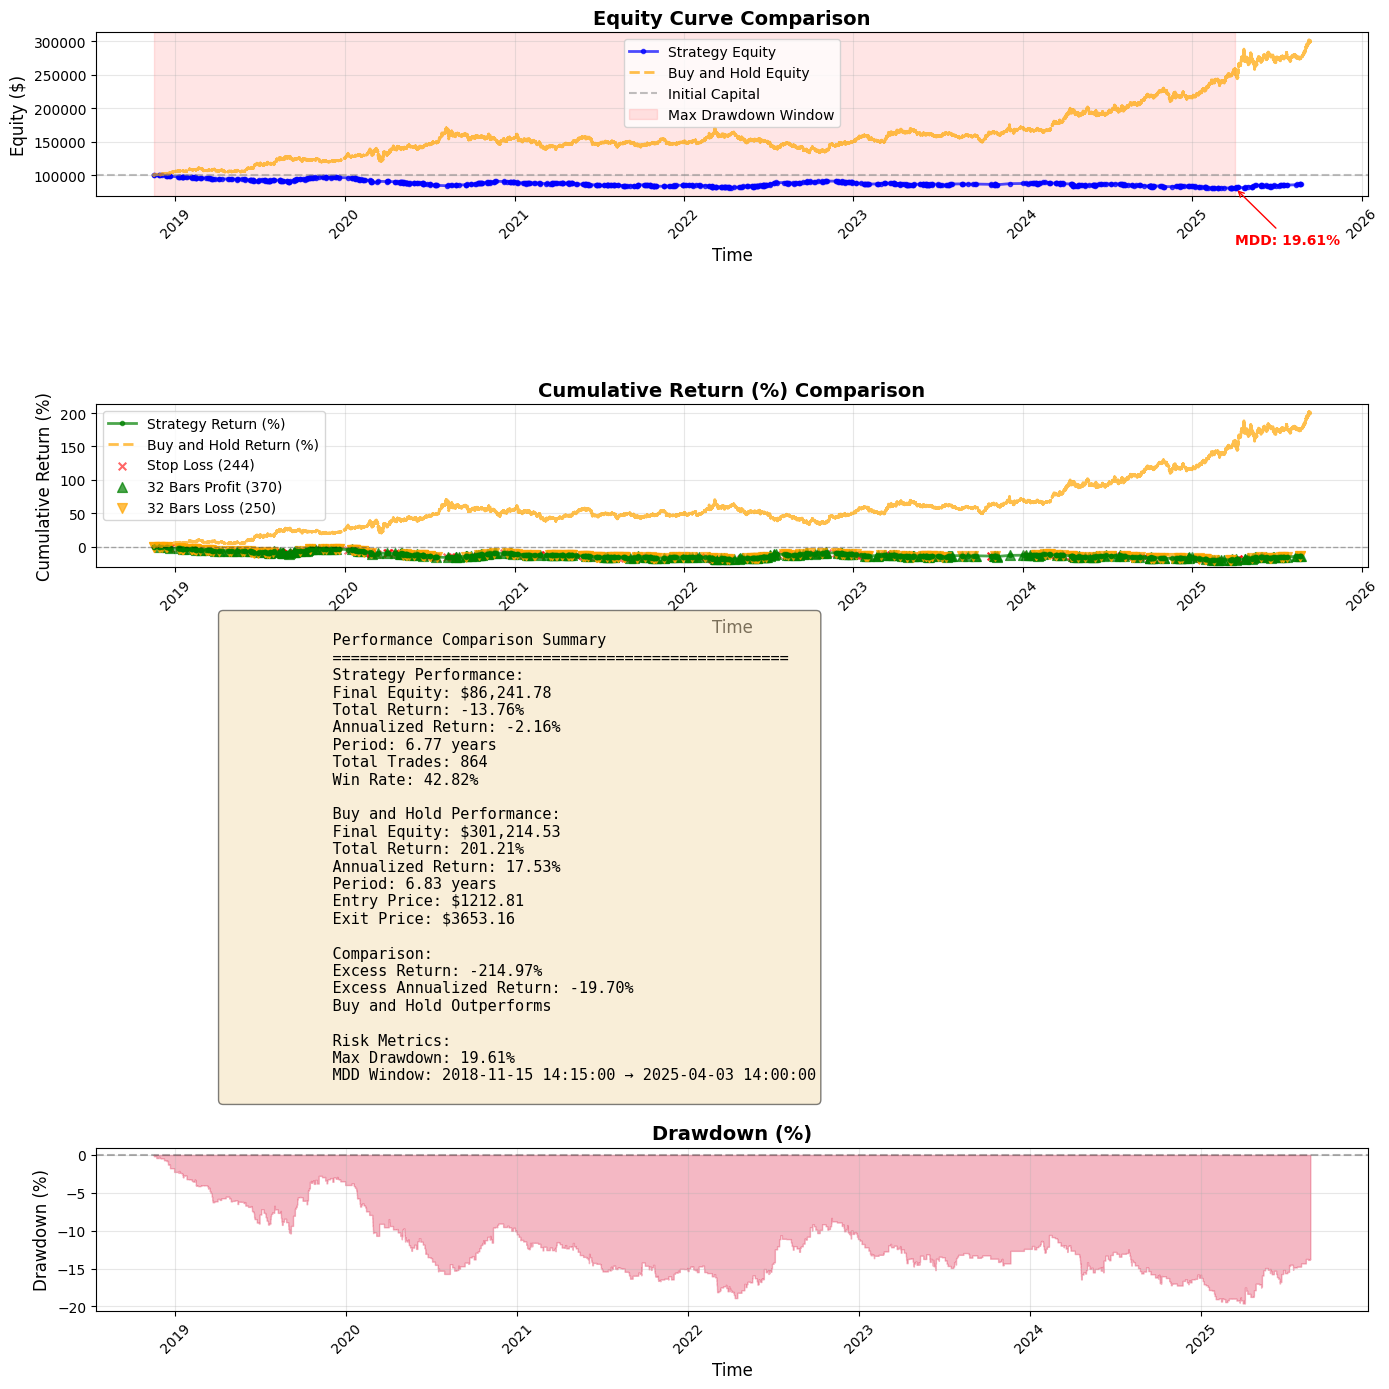


詳細績效指標:
Initial Capital: 100000
Final Equity: 86241.78492582352
Total PnL: -13758.215074176458
Total Return (%): -13.758215074176478
Total Trades: 864
Winning Trades: 370
Losing Trades: 494
Win Rate (%): 42.824074074074076
Average Return (%): -0.01601701391446532
Average Win (%): 0.4102905349095852
Average Loss (%): -0.3353161901591995
Average Win Amount: 355.9843478143262
Average Loss Amount: -294.4785906183748
Profit Factor: 0.9054238960343665
Stop Loss Count: 244
Take Profit Pct Count: 0
Take Profit Pct Win Count: 0
Take Profit Pct Loss Count: 0
Take Profit Bars Count: 620
Take Profit Bars Win Count: 370
Take Profit Bars Loss Count: 250
Leverage 0.5x Count: 0
Leverage 1.0x Count: 864
Leverage 2.0x Count: 0
📊 每月統計摘要
總月份數: 82
賺錢月份: 37 (45.12%)
虧錢月份: 45 (54.88%)

每月詳細統計:
------------------------------------------------------------
2018-11: Loss   | PnL: $   -487.39 | Trades:    5 | Win Rate:  20.00%
2018-12: Loss   | PnL: $ -1,340.89 | Trades:    7 | Win Rate:  28.57%
2019-01: Loss   

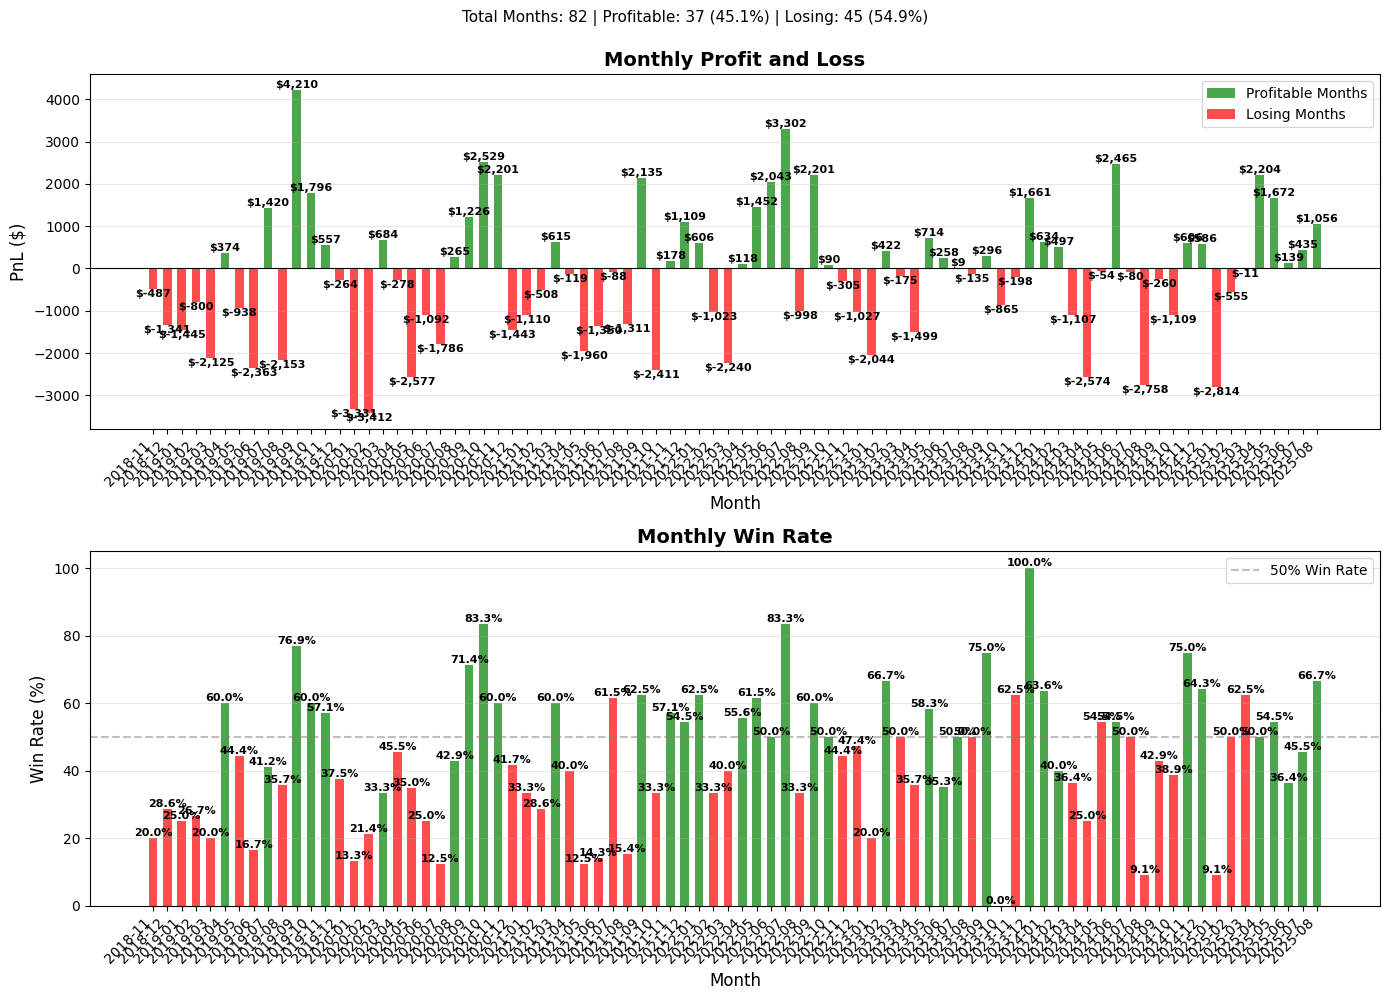

In [142]:
# 使用範例
# 假設你已經有 nas100_raw 資料和 L1Strategy 策略

# 1. 初始化策略並計算信號
strategy = S1Strategy(entry_param=0.5, rolling_window=500)
df_with_signals = strategy.calculate_indicators(nas100_raw)

# 2. 初始化回測引擎（0.25%停損，32根K停利）
backtest = BacktestEngine(stop_loss_pct=0.005, take_profit_bars=32)
# backtest = BacktestEngine(stop_loss_pct=0.0025, take_profit_pct=0.0025, take_profit_bars=32)


# 3. 執行回測
results = backtest.backtest(
    df=df_with_signals[['Open', 'High', 'Low', 'Close']],
    signals=df_with_signals['signal']
)

# 4. 查看結果
print("\n前10筆交易:")
print(results.tail(10))

# 5. 查看績效摘要
backtest.print_summary()

# 6. 繪製權益曲線
backtest.plot_equity_curve()

# 7. 查看詳細績效指標
metrics = backtest.get_performance_metrics()
print("\n詳細績效指標:")
for key, value in metrics.items():
    print(f"{key}: {value}")
    
# 8. 查看每月統計摘要
backtest.print_monthly_summary()
backtest.plot_monthly_pnl()
monthly_stats = backtest.get_monthly_statistics()

In [143]:
# 使用範例
# 假設你已經有 nas100_raw 資料和 L1Strategy 策略

# 1. 初始化策略並計算信號
strategy = S1Strategy(entry_param=0.5, rolling_window=500)
df_with_signals = strategy.calculate_indicators(nas100_raw)

# 2. 初始化回測引擎（0.25%停損，32根K停利）
backtest = BacktestEngine(stop_loss_pct=0.005, take_profit_pct=0.005, take_profit_bars=32)
# backtest = BacktestEngine(stop_loss_pct=0.0025, take_profit_pct=0.0025, take_profit_bars=32)


# 3. 執行回測
results = backtest.backtest(
    df=df_with_signals[['Open', 'High', 'Low', 'Close']],
    signals=df_with_signals['signal']
)

# 4. 查看結果
print("\n前10筆交易:")
print(results.head(10))

# 5. 查看績效摘要
backtest.print_summary()

# 6. 繪製權益曲線
backtest.plot_equity_curve()

# 7. 查看詳細績效指標
metrics = backtest.get_performance_metrics()
print("\n詳細績效指標:")
for key, value in metrics.items():
    print(f"{key}: {value}")
    
# 8. 查看每月統計摘要
backtest.print_monthly_summary()
backtest.plot_monthly_pnl()
monthly_stats = backtest.get_monthly_statistics()

📊 S1 策略統計 (Short)
總 K 線數: 162,577
信號數量: 3,036
信號比例: 1.8674%
策略參數: entry_param=0.5, entry_param2=0.4, rolling_window=500


KeyboardInterrupt: 

In [ ]:
# results.tail(50)

## 策略訊號 + ML篩選進場

只進預測1

In [ ]:
class S1LeverageStrategy:
    """S1 策略 (做空版本) + ML 預測篩選 + 槓桿調整"""

    def __init__(
        self,
        entry_param: float = 0.5,
        rolling_window: int = 460,
        ml_pred_file: str = 'Pred_xgb.csv',
        allowed_predicted_labels: Optional[Iterable[int]] = None,
        leverage_map: Optional[Dict[int, float]] = None,
    ):
        self.entry_param = entry_param
        self.rolling_window = rolling_window
        self.ml_pred_file = ml_pred_file
        self.signals = None

        # 允許的 predicted_label；None 代表不過濾
        self.allowed_predicted_labels = (
            set(allowed_predicted_labels) if allowed_predicted_labels is not None else None
        )

        # 槓桿映射預設：-1/0/1 對應 0.5x / 1.0x / 2.0x
        # 註：若 ML 是 Meta Labeling (1=好交易, -1=壞交易)，則維持此映射。
        self.leverage_map = leverage_map or {-1: 0.5, 0: 1.0, 1: 2.0}

        self.ml_predictions = None
        self.ml_predicted_labels = None
        self.ml_start_time = None

        self._load_ml_predictions()

    def _load_ml_predictions(self):
        """載入 ML 預測檔（須含 Date 與 predicted_label 欄位）"""
        try:
            ml_df = pd.read_csv(self.ml_pred_file)

            date_col = 'Date' if 'Date' in ml_df.columns else ml_df.columns[0]
            ml_df[date_col] = pd.to_datetime(ml_df[date_col])
            ml_df.set_index(date_col, inplace=True)
            ml_df.sort_index(inplace=True)

            if 'predicted_label' not in ml_df.columns:
                raise ValueError(f"{self.ml_pred_file} 缺少 predicted_label 欄位")

            self.ml_predicted_labels = ml_df['predicted_label']
            self.ml_predictions = self.ml_predicted_labels.map(self.leverage_map).fillna(1.0)
            self.ml_start_time = self.ml_predictions.index[0]

            print(f"✅ 載入 {self.ml_pred_file}：{len(self.ml_predictions):,} 筆")
            print(f"   時間範圍：{self.ml_predictions.index[0]} ~ {self.ml_predictions.index[-1]}")
            print("   predicted_label 分布：")
            for label, count in self.ml_predicted_labels.value_counts().sort_index().items():
                print(f"     {label}: {count:,}")
        except Exception as e:
            print(f"⚠️ 載入 ML 預測失敗：{e}")
            self.ml_predictions = pd.Series(dtype=float)
            self.ml_predicted_labels = pd.Series(dtype=float)
            self.ml_start_time = None

    def calculate_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()

        if self.ml_start_time is not None:
            df = df.loc[df.index >= self.ml_start_time].copy()
        else:
            print("⚠️ 尚未讀到 ML 預測資料，使用全部價格資料")

        # 波動率計算維持不變
        df['HL115'] = (
            df['High'].shift(1).rolling(self.rolling_window, min_periods=self.rolling_window).max()
            - df['Low'].shift(1).rolling(self.rolling_window, min_periods=self.rolling_window).min()
        )
        # 分母改為 High 較為對稱，但若要維持計算邏輯一致性也可維持 Low
        df['HL115%'] = df['HL115'] / df['High'].shift(self.rolling_window + 1)

        # S1 修改：基準價為 High 的 rolling max，方向為減去波動
        df['突破signal價'] = (
            df['High'].shift(1).rolling(self.rolling_window).max() - self.entry_param * df['HL115']
        )
        df['突破signal價%'] = df['突破signal價'] / df['Open']

        df['signal'] = False
        # S1 修改：做空信號 (Low 跌破 突破價 且 Open 在 突破價之上)
        df['signal'] = (
            (df['signal'].shift(1) == False)
            & (df['Low'] < df['突破signal價'])
            & (df['Open'] > df['突破signal價'])
        )

        df['leverage'] = 1.0
        df['predicted_label'] = np.nan

        if self.ml_predictions is not None and len(self.ml_predictions) > 0:
            # 以價格索引對齊 ML 預測
            aligned_labels = self.ml_predicted_labels.reindex(df.index, method='ffill')
            aligned_leverage = aligned_labels.map(self.leverage_map).fillna(1.0)

            df['predicted_label'] = aligned_labels
            df['leverage'] = aligned_leverage

            signal_labels = df.loc[df['signal'], 'predicted_label'].dropna()
            matched = len(signal_labels)
            total_signals = int(df['signal'].sum())
            print(f"✅ S1 信號 {total_signals:,} 筆，成功匹配 {matched:,} 筆 ML 預測")
            if matched > 0:
                for label, count in signal_labels.value_counts().sort_index().items():
                    lev = self.leverage_map.get(label, 1.0)
                    print(f"   predicted_label={label}: {count:,} (leverage={lev}x)")
        else:
            print("⚠️ 無 ML 槓桿資料，全部使用 1.0x")

        if self.allowed_predicted_labels is not None:
            allowed_mask = df['predicted_label'].isin(self.allowed_predicted_labels).fillna(False)
            blocked = int(df['signal'].sum() - (df['signal'] & allowed_mask).sum())
            df['signal'] = df['signal'] & allowed_mask
            df.loc[~allowed_mask, 'leverage'] = 1.0
            print(f"🔍 ML 過濾：排除 {blocked:,} 筆不在 {sorted(self.allowed_predicted_labels)} 的信號")

        df['side'] = np.nan
        # S1 修改：做空 side = -1.0
        df.loc[df['signal'], 'side'] = -1.0
        df['side'] = df['side'].ffill()
        df['side'] = -1

        self.signals = df

        signal_df = df[df['signal']]
        leverage_counts = signal_df['leverage'].value_counts().sort_index()

        print("=" * 60)
        print("📊 S1 + ML 策略統計 (做空)")
        print("=" * 60)
        print(f"總 K 線數: {len(df):,}")
        print(f"S1 信號數: {len(signal_df):,}")
        for lev, count in leverage_counts.items():
            print(f"  槓桿 {lev}x: {count:,} 筆")
        print("=" * 60)

        return df

    def get_signal_events(self) -> pd.DatetimeIndex:
        if self.signals is None:
            print("⚠️ 請先執行 calculate_indicators()")
            return None
        return self.signals.index[self.signals['signal']]

    def get_signal_stats(self) -> dict:
        if self.signals is None:
            return {}
        sig = self.signals[self.signals['signal']]
        total = len(sig)
        counts = sig['leverage'].value_counts().to_dict()
        return {
            'total_signals': total,
            'signal_rate': total / len(self.signals),
            'leverage_counts': counts,
            'avg_HL115': self.signals['HL115'].mean(),
            'avg_price_to_signal': (self.signals['Close'] / self.signals['突破signal價']).mean(),
        }

In [ ]:
# 使用範例
# 假設你已經載入 nas100_raw (含 Open/High/Low/Close)

# dt et lightgbm lr nb rf svm xgboost
ML_PRED_FILE = r'C:\Users\a124a\OneDrive\桌面\策略開發\MetaLabelLearning\MetaNewLow\pred_results\pred_xgboost_2020_2025.csv'                # 指定要使用的預測檔
ALLOWED_PRED_LABELS = {1,  0, }                # 只允許 predicted_label = 1 或 0 進場
# LEVERAGE_MAP = {-1: 1, 0: 1, 1: 1}    # 需要的槓桿對應
LEVERAGE_MAP = {-1: 1, 0: 1, 1: 2} 

# 1. 初始化策略（結合 L1 + ML）
strategy = S1LeverageStrategy(
    entry_param=0.5,
    rolling_window=500,
    ml_pred_file=ML_PRED_FILE,
    allowed_predicted_labels=ALLOWED_PRED_LABELS,
    leverage_map=LEVERAGE_MAP
)
df_with_signals = strategy.calculate_indicators(nas100_raw)

# 2. 初始化回測引擎（例：0.25% 停損，32 根 K 停利）
backtest = BacktestEngine(stop_loss_pct=0.005, take_profit_bars=32)
# backtest = BacktestEngine(stop_loss_pct=0.0025, take_profit_bars=32, take_profit_pct=0.0025)


# 3. 執行回測
results = backtest.backtest(
    df=df_with_signals[['Open', 'High', 'Low', 'Close']],
    signals=df_with_signals['signal'],
    leverage_series=df_with_signals['leverage']  # 傳入 ML 調整後的槓桿
)

# 4. 查看結果
print("\n前10筆交易:")
print(results.tail(10))

# 5. 查看績效摘要與圖表
backtest.print_summary()
backtest.plot_equity_curve()

# 6. 詳細指標與每月統計
metrics = backtest.get_performance_metrics()
print("\n詳細績效指標:")
for key, value in metrics.items():
    print(f"{key}: {value}")

backtest.print_monthly_summary()
backtest.plot_monthly_pnl()
monthly_stats = backtest.get_monthly_statistics()

✅ 載入 C:\Users\a124a\OneDrive\桌面\策略開發\MetaLabelLearning\MetaNewLow\pred_results\pred_xgboost_2020_2025.csv：1,027 筆
   時間範圍：2020-01-29 14:45:00 ~ 2025-08-05 14:15:00
   predicted_label 分布：
     -1: 279
     0: 39
     1: 709
✅ S1 信號 2,762 筆，成功匹配 2,762 筆 ML 預測
   predicted_label=-1: 670 (leverage=1x)
   predicted_label=0: 217 (leverage=1x)
   predicted_label=1: 1,875 (leverage=2x)
🔍 ML 過濾：排除 670 筆不在 [0, 1] 的信號
📊 S1 + ML 策略統計 (做空)
總 K 線數: 133,426
S1 信號數: 2,092
  槓桿 1x: 217 筆
  槓桿 2x: 1,875 筆


KeyboardInterrupt: 

預測信心調整部位

In [ ]:
class S1LeverageStrategy:
    """S1 策略 (做空版本) + ML 預測篩選 (含信心度) + 槓桿調整"""

    def __init__(
        self,
        entry_param: float = 0.5,
        rolling_window: int = 460,
        ml_pred_file: str = 'Pred_xgb.csv',
        allowed_predicted_labels: Optional[Iterable[int]] = None,
        leverage_map: Optional[Dict[int, float]] = None,
    ):
        self.entry_param = entry_param
        self.rolling_window = rolling_window
        self.ml_pred_file = ml_pred_file
        self.signals = None

        # 允許的 predicted_label；None 代表不過濾
        self.allowed_predicted_labels = (
            set(allowed_predicted_labels) if allowed_predicted_labels is not None else None
        )

        # 保留舊有映射 (可能仍需 fallback)
        self.leverage_map = leverage_map or {-1: 0.5, 0: 1.0, 1: 2.0}

        self.ml_predictions = None
        self.ml_predicted_labels = None
        self.ml_prediction_confidence = None
        self.ml_start_time = None

        self._load_ml_predictions()

    def _load_ml_predictions(self):
        """載入 ML 預測檔（須含 Date、predicted_label、prediction_confidence 欄位）"""
        try:
            ml_df = pd.read_csv(self.ml_pred_file)

            date_col = 'Date' if 'Date' in ml_df.columns else ml_df.columns[0]
            ml_df[date_col] = pd.to_datetime(ml_df[date_col])
            ml_df.set_index(date_col, inplace=True)
            ml_df.sort_index(inplace=True)

            if 'predicted_label' not in ml_df.columns:
                raise ValueError(f"{self.ml_pred_file} 缺少 predicted_label 欄位")
            if 'prediction_confidence' not in ml_df.columns:
                raise ValueError(f"{self.ml_pred_file} 缺少 prediction_confidence 欄位")

            self.ml_predicted_labels = ml_df['predicted_label']
            self.ml_prediction_confidence = (
                ml_df['prediction_confidence']
                .astype(float)
                .clip(lower=0.0)
                .fillna(0.0)
            )

            # 根據 label + confidence 轉成槓桿
            leverage_series = pd.Series(1.0, index=ml_df.index, dtype=float)
            
            # Label -1 (Bad Trade): 降槓桿
            leverage_series[self.ml_predicted_labels == -1] = (
                1.0 - (self.ml_prediction_confidence * 1.0).clip(upper=0.66)
            )
            # Label 1 (Good Trade): 加槓桿
            leverage_series[self.ml_predicted_labels == 1] = (
                1.0 + (self.ml_prediction_confidence * 1.0)  # 建議加上槓桿上限
            )
            self.ml_predictions = leverage_series
            self.ml_start_time = leverage_series.index[0]

            print(f"✅ 載入 {self.ml_pred_file}：{len(self.ml_predictions):,} 筆")
            print(f"   時間範圍：{self.ml_predictions.index[0]} ~ {self.ml_predictions.index[-1]}")
            print("   predicted_label 分布：")
            for label, count in self.ml_predicted_labels.value_counts().sort_index().items():
                print(f"     {label}: {count:,}")
        except Exception as e:
            print(f"⚠️ 載入 ML 預測失敗：{e}")
            self.ml_predictions = pd.Series(dtype=float)
            self.ml_predicted_labels = pd.Series(dtype=float)
            self.ml_prediction_confidence = pd.Series(dtype=float)
            self.ml_start_time = None

    def calculate_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()

        if self.ml_start_time is not None:
            df = df.loc[df.index >= self.ml_start_time].copy()
        else:
            print("⚠️ 尚未讀到 ML 預測資料，使用全部價格資料")

        # 波動率區間計算
        df['HL115'] = (
            df['High'].shift(1).rolling(self.rolling_window, min_periods=self.rolling_window).max()
            - df['Low'].shift(1).rolling(self.rolling_window, min_periods=self.rolling_window).min()
        )
        # S1: 分母改用 High 較合理
        df['HL115%'] = df['HL115'] / df['High'].shift(self.rolling_window + 1)

        # S1 修改：基準價 High Max - 波動
        df['突破signal價'] = (
            df['High'].shift(1).rolling(self.rolling_window).max() - self.entry_param * df['HL115']
        )
        df['突破signal價%'] = df['突破signal價'] / df['Open']

        df['signal'] = False
        # S1 修改：做空信號 (Low 跌破 突破價 且 Open 在 突破價之上)
        df['signal'] = (
            (df['signal'].shift(1) == False)
            & (df['Low'] < df['突破signal價'])
            & (df['Open'] > df['突破signal價'])
        )

        df['leverage'] = 1.0
        df['predicted_label'] = np.nan

        if self.ml_predictions is not None and len(self.ml_predictions) > 0:
            aligned_labels = self.ml_predicted_labels.reindex(df.index, method='ffill')
            aligned_leverage = self.ml_predictions.reindex(df.index, method='ffill').fillna(1.0)

            df['predicted_label'] = aligned_labels
            df['leverage'] = aligned_leverage

            signal_labels = df.loc[df['signal'], 'predicted_label'].dropna()
            matched = len(signal_labels)
            total_signals = int(df['signal'].sum())
            print(f"✅ S1 信號 {total_signals:,} 筆，成功匹配 {matched:,} 筆 ML 預測")
            if matched > 0:
                for label, count in signal_labels.value_counts().sort_index().items():
                    lev_desc = "1 - conf" if label == -1 else ("1 + conf" if label == 1 else "1")
                    print(f"   predicted_label={label}: {count:,} (leverage rule: {lev_desc})")
        else:
            print("⚠️ 無 ML 槓桿資料，全部使用 1.0x")

        if self.allowed_predicted_labels is not None:
            allowed_mask = df['predicted_label'].isin(self.allowed_predicted_labels).fillna(False)
            blocked = int(df['signal'].sum() - (df['signal'] & allowed_mask).sum())
            df['signal'] = df['signal'] & allowed_mask
            df.loc[~allowed_mask, 'leverage'] = 1.0
            print(f"🔍 ML 過濾：排除 {blocked:,} 筆不在 {sorted(self.allowed_predicted_labels)} 的信號")

        df['side'] = np.nan
        # S1 修改：做空 side = -1.0
        df.loc[df['signal'], 'side'] = -1.0
        df['side'] = df['side'].ffill()
        df['side'] = -1

        self.signals = df

        signal_df = df[df['signal']]
        leverage_counts = signal_df['leverage'].round(4).value_counts().sort_index()

        print("=" * 60)
        print("📊 S1 + ML 策略統計 (做空)")
        print("=" * 60)
        print(f"總 K 線數: {len(df):,}")
        print(f"S1 信號數: {len(signal_df):,}")
        for lev, count in leverage_counts.items():
            print(f"  槓桿 {lev}x: {count:,} 筆")
        print("=" * 60)

        return df

    def get_signal_events(self) -> pd.DatetimeIndex:
        if self.signals is None:
            print("⚠️ 請先執行 calculate_indicators()")
            return None
        return self.signals.index[self.signals['signal']]

    def get_signal_stats(self) -> dict:
        if self.signals is None:
            return {}
        sig = self.signals[self.signals['signal']]
        total = len(sig)
        counts = sig['leverage'].value_counts().to_dict()
        return {
            'total_signals': total,
            'signal_rate': total / len(self.signals),
            'leverage_counts': counts,
            'avg_HL115': self.signals['HL115'].mean(),
            'avg_price_to_signal': (self.signals['Close'] / self.signals['突破signal價']).mean(),
        }

✅ 載入 C:\Users\a124a\OneDrive\桌面\策略開發\MetaLabelLearning\MetaNewLow\pred_results\pred_lr_2020_2025.csv：1,027 筆
   時間範圍：2020-01-29 14:45:00 ~ 2025-08-05 14:15:00
   predicted_label 分布：
     -1: 372
     0: 192
     1: 463
✅ S1 信號 5,434 筆，成功匹配 5,434 筆 ML 預測
   predicted_label=-1: 1,164 (leverage rule: 1 - conf)
   predicted_label=0: 1,375 (leverage rule: 1)
   predicted_label=1: 2,895 (leverage rule: 1 + conf)
📊 S1 + ML 策略統計 (做空)
總 K 線數: 131,978
S1 信號數: 5,434
  槓桿 0.34x: 824 筆
  槓桿 0.3403x: 1 筆
  槓桿 0.3438x: 4 筆
  槓桿 0.3533x: 10 筆
  槓桿 0.3597x: 9 筆
  槓桿 0.3609x: 1 筆
  槓桿 0.3772x: 2 筆
  槓桿 0.3909x: 7 筆
  槓桿 0.4205x: 180 筆
  槓桿 0.438x: 13 筆
  槓桿 0.4401x: 1 筆
  槓桿 0.4576x: 6 筆
  槓桿 0.4608x: 1 筆
  槓桿 0.4975x: 13 筆
  槓桿 0.5068x: 8 筆
  槓桿 0.5402x: 2 筆
  槓桿 0.5436x: 35 筆
  槓桿 0.5611x: 47 筆
  槓桿 1.0x: 1,375 筆
  槓桿 1.3851x: 3 筆
  槓桿 1.3898x: 21 筆
  槓桿 1.4056x: 1 筆
  槓桿 1.453x: 32 筆
  槓桿 1.4586x: 302 筆
  槓桿 1.471x: 21 筆
  槓桿 1.5015x: 64 筆
  槓桿 1.5103x: 28 筆
  槓桿 1.541x: 22 筆
  槓桿 1.5632x: 8 筆
  槓桿 1

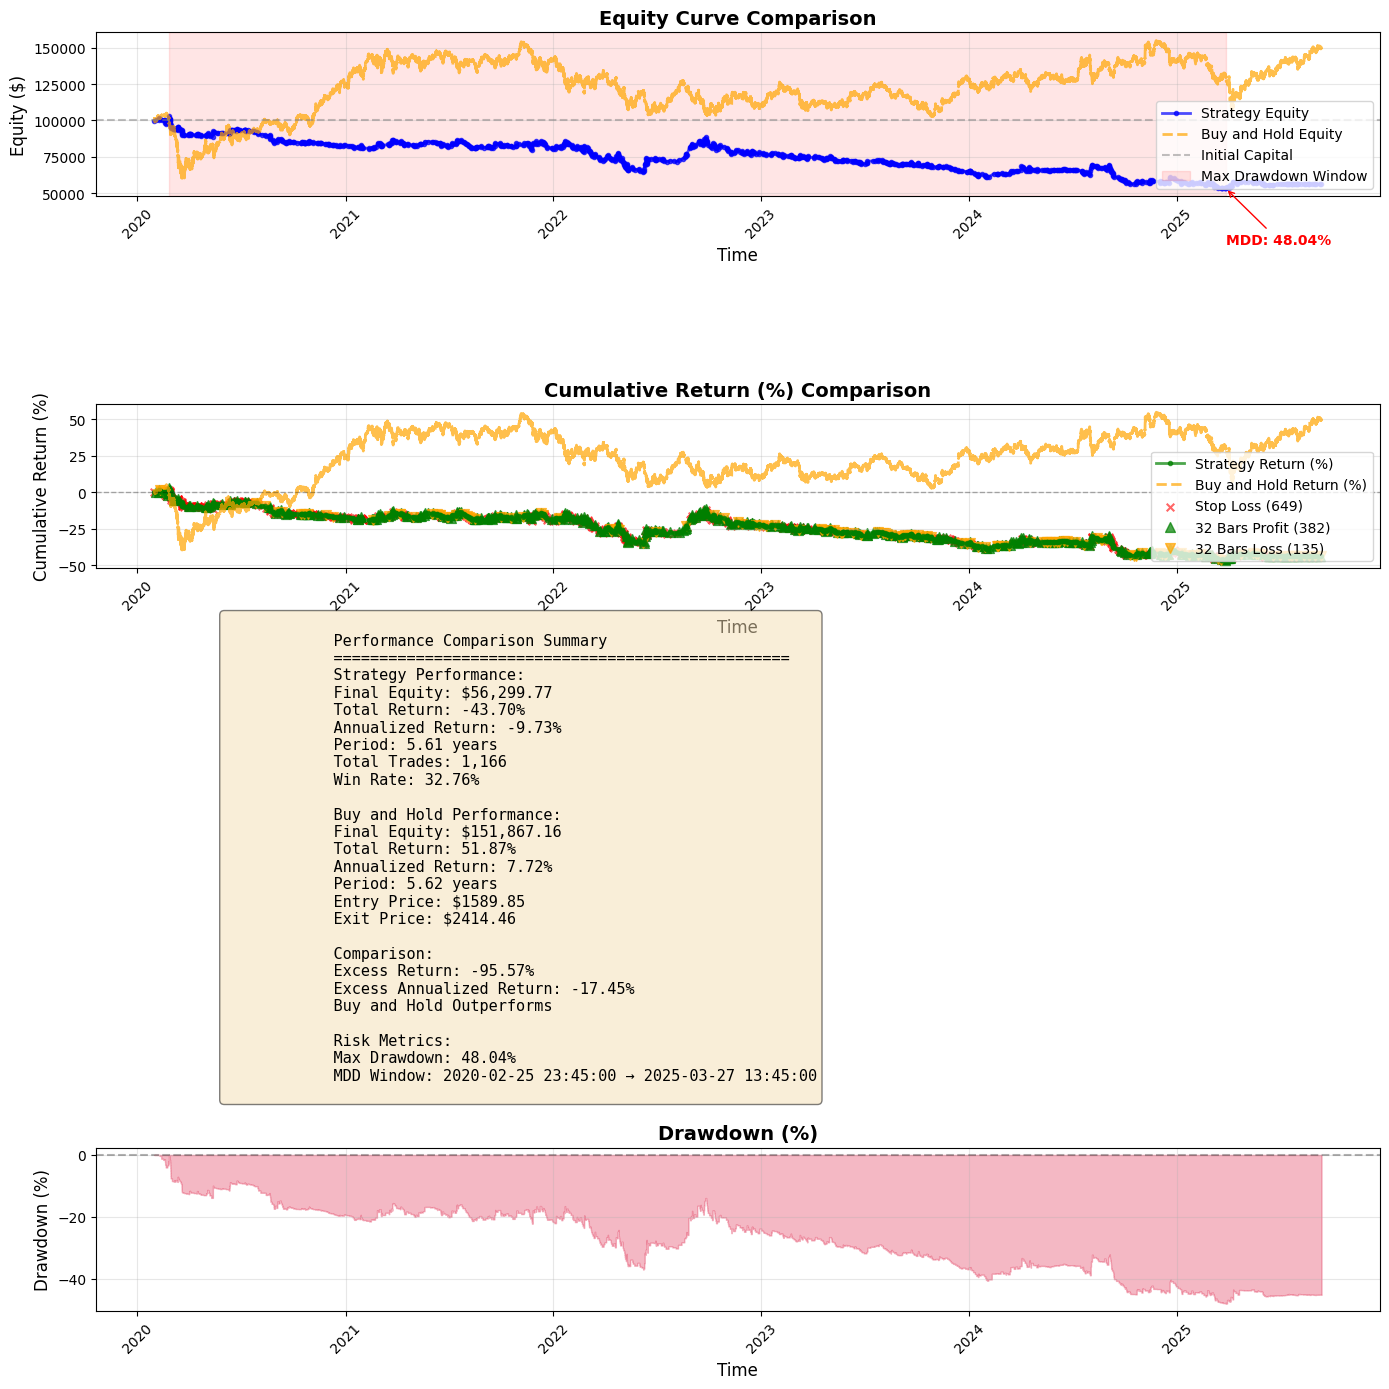


詳細績效指標:
Initial Capital: 100000
Final Equity: 56299.76918321292
Total PnL: -43700.23081678721
Total Return (%): -43.70023081678708
Total Trades: 1166
Winning Trades: 382
Losing Trades: 784
Win Rate (%): 32.76157804459691
Average Return (%): -0.04407025454267447
Average Win (%): 1.0297148300951378
Average Loss (%): -0.5672665585371187
Average Win Amount: 759.7141025852393
Average Loss Amount: -425.90691071983247
Profit Factor: 0.8691261190542141
Stop Loss Count: 649
Take Profit Pct Count: 0
Take Profit Pct Win Count: 0
Take Profit Pct Loss Count: 0
Take Profit Bars Count: 517
Take Profit Bars Win Count: 382
Take Profit Bars Loss Count: 135
Leverage 0.5x Count: 0
Leverage 1.0x Count: 310
Leverage 2.0x Count: 0
📊 每月統計摘要
總月份數: 69
賺錢月份: 29 (42.03%)
虧錢月份: 40 (57.97%)

每月詳細統計:
------------------------------------------------------------
2020-01: Loss   | PnL: $   -180.60 | Trades:    1 | Win Rate:   0.00%
2020-02: Loss   | PnL: $ -4,852.29 | Trades:   25 | Win Rate:  32.00%
2020-03: Loss   |

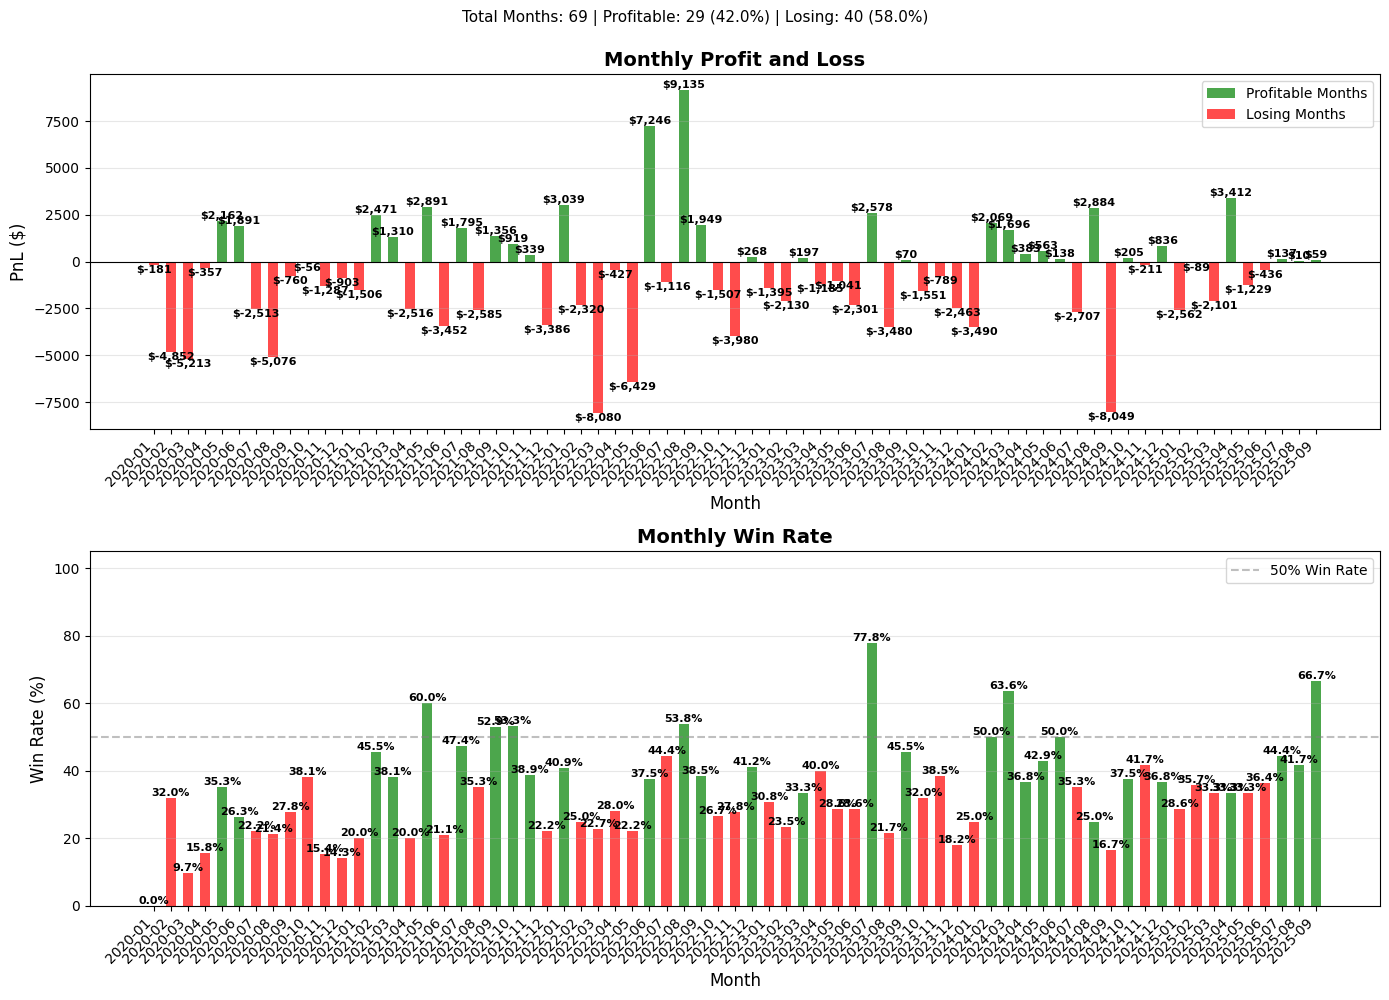

In [ ]:
# 使用範例
# 假設你已經載入 nas100_raw (含 Open/High/Low/Close)

# === 可調整參數 ===
# dt et lightgbm lr nb rf svm xgboost
ML_PRED_FILE = r'C:\Users\a124a\OneDrive\桌面\策略開發\MetaLabelLearning\MetaNewLow\pred_results\pred_lr_2020_2025.csv'                # 指定要使用的預測檔
ALLOWED_PRED_LABELS = {1, 0, -1}                # 只允許 predicted_label = 1 或 0 進場
# LEVERAGE_MAP = {-1: 1, 0: 1, 1: 1}    # 需要的槓桿對應
LEVERAGE_MAP = {-1: 0.5, 0: 1, 1: 2} 

# 1. 初始化策略（結合 L1 + ML）
strategy = S1LeverageStrategy(
    entry_param=1,
    rolling_window=96,
    ml_pred_file=ML_PRED_FILE,
    allowed_predicted_labels=None,
)
df_with_signals = strategy.calculate_indicators(nas100_raw)

# 2. 初始化回測引擎（例：0.25% 停損，32 根 K 停利）
backtest = BacktestEngine(stop_loss_pct=0.005, take_profit_bars=32)
# backtest = BacktestEngine(stop_loss_pct=0.0025, take_profit_bars=32, take_profit_pct=0.0025)


# 3. 執行回測
results = backtest.backtest(
    df=df_with_signals[['Open', 'High', 'Low', 'Close']],
    signals=df_with_signals['signal'],
    leverage_series=df_with_signals['leverage']  # 傳入 ML 調整後的槓桿
)

# 4. 查看結果
print("\n前10筆交易:")
print(results.head(10))

# 5. 查看績效摘要與圖表
backtest.print_summary()
backtest.plot_equity_curve()

# 6. 詳細指標與每月統計
metrics = backtest.get_performance_metrics()
print("\n詳細績效指標:")
for key, value in metrics.items():
    print(f"{key}: {value}")

backtest.print_monthly_summary()
backtest.plot_monthly_pnl()
monthly_stats = backtest.get_monthly_statistics()